# Introducción

Este Notebook presenta el proceso de análisis y modelado para predecir la probabilidad de que un cliente contrate el producto "payroll". Utilizaremos un conjunto de datos que contiene información sobre las características demográficas y de comportamiento de los clientes, así como sus interacciones previas con el banco.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Importación de librerías y carga de datos

Importamos las librerías necesarias para el análisis y modelado de datos. Pandas se utilizará para la manipulación de datos, NumPy para operaciones numéricas, sklearn para el modelado y matplotlib para la visualización de datos.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from pandas.tseries.offsets import DateOffset
from sklearn import metrics
import matplotlib.pyplot as plt

# 2. Cargar y revisar de los datos
Se carga el archivo CSV que contiene los datos y se utiliza el método info() para obtener una descripción general de los datos, incluyendo el número total de entradas y la cantidad de valores no nulos.

In [ ]:
csv_path = '/content/drive/MyDrive/Colab Notebooks/MDS - Grupo 7/Capstone/Dataset para trabajar 04.07/informacion_clientes.csv'

In [ ]:
# Cargar los datos
df = pd.read_csv(csv_path)

<ipython-input-4-3d142995c8f4>:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 27 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   pk_cid                  int64  
 1   pk_partition            object 
 2   entry_date              object 
 3   entry_channel           object 
 4   active_customer         int64  
 5   segment                 object 
 6   short_term_deposit      int64  
 7   loans                   int64  
 8   mortgage                int64  
 9   funds                   int64  
 10  securities              int64  
 11  long_term_deposit       int64  
 12  credit_card             int64  
 13  payroll                 int64  
 14  pension_plan            int64  
 15  payroll_account         int64  
 16  emc_account             int64  
 17  debit_card              int64  
 18  em_acount               int64  
 19  country_id              object 
 20  region_code             object 
 21  gender                  object 

Definimos payroll como objetivo para realizar las acciones posteriores

In [ ]:
target = "payroll"

# 3. Preprocesamiento y preparación de los datos
Se procesan los datos para prepararlos para el análisis. Esto incluye la ordenación de los datos por cliente y mes, la creación de nuevas columnas que indican si el cliente ha comprado en el mes anterior y hace dos meses, y la conversión de la columna de fecha a tipo datetime.

In [ ]:
df = df.sort_values(['pk_cid', 'pk_partition'])

In [ ]:
df[target].value_counts()

0    5757137
1     205787
Name: payroll, dtype: int64

In [ ]:
# Convertir la columna 'month_sale' a tipo de dato datetime
df['pk_partition'] = pd.to_datetime(df['pk_partition'])

In [ ]:
df['region_code'] = df['region_code'].replace('no_data', '0.0')

In [ ]:
df['region_code'] = df['region_code'].astype(float)

In [ ]:
df['Suma_productos_activos']= df['Suma_productos_activos'] - df[target]

# 4. Creación del conjunto de datos balanceado
Aquí se utiliza la función create_dataset, la cual definimos para crear un conjunto de datos balanceado.

In [ ]:
def create_dataset(df):
    dataset = pd.DataFrame()  # Crear un DataFrame vacío para almacenar los datos muestreados
    selected_cids = set()  # Crear un conjunto para almacenar los cids seleccionados

    months = sorted(df['pk_partition'].unique())  # Almacena los meses únicos en la columna 'month_sale', en orden
    for month in months[:-1]:  # Iterar sobre todos los meses, excepto el último
        month_df = df[df['pk_partition'] == month]  # Filtrar el DataFrame original para el mes actual
        # Excluir los cids que ya han sido seleccionados
        data_with_purchase = month_df[(month_df[target] == 1) & (~month_df['pk_cid'].isin(selected_cids))]
        data_without_purchase = month_df[(month_df[target] == 0) & (~month_df['pk_cid'].isin(selected_cids))]
        sample_size = min(len(data_with_purchase), len(data_without_purchase))  # Calcular el tamaño de muestra mínimo

        print(f'Mes: {month}')  # Imprimir el mes actual
        print(f'Número de 1s: {len(data_with_purchase)}')  # Imprimir el número de 1s para el mes actual
        print(f'Número de 0s: {len(data_without_purchase)}')  # Imprimir el número de 0s para el mes actual
        print(f'Tamaño de la muestra: {sample_size}\n')  # Imprimir el tamaño de la muestra para el mes actual

        if sample_size > 0:  # Verificar que haya suficientes clientes en ambas categorías para crear un dataset equilibrado
            sampled_data_with_purchase = data_with_purchase.sample(n=sample_size, random_state=42)  # Tomar sample_size datos de los clientes que compraron
            sampled_data_without_purchase = data_without_purchase.sample(n=sample_size, random_state=42)  # Tomar sample_size datos de los clientes que no compraron
            sampled_data = pd.concat([sampled_data_with_purchase, sampled_data_without_purchase])  # Concatenar los datos muestreados
            dataset = pd.concat([dataset, sampled_data])  # Agregar los datos muestreados al dataset final
            # Actualizar los cids seleccionados
            selected_cids.update(sampled_data['pk_cid'].values)

    # Tratar el último mes por separado
    last_month = months[-1]
    last_month_df = df[df['pk_partition'] == last_month]  # Filtrar el DataFrame original para el último mes
    # Aquí no necesitamos equilibrar los datos, así que simplemente excluimos los cids que ya han sido seleccionados
    last_month_data = last_month_df[~last_month_df['pk_cid'].isin(selected_cids)]

    # Imprimir las estadísticas del último mes
    print(f'Mes: {last_month}')
    print(f'Número de 1s: {len(last_month_data[last_month_data[target] == 1])}')
    print(f'Número de 0s: {len(last_month_data[last_month_data[target] == 0])}')

    # Agregar los datos del último mes al dataset final
    dataset = pd.concat([dataset, last_month_data])

    return dataset  # Devolver el dataset consolidado de todos los meses


In [ ]:
# Crear el dataset por meses y consolidar las ventas
dataset = create_dataset(df)

Mes: 2018-01-01T00:00:00.000000000
Número de 1s: 8145
Número de 0s: 231348
Tamaño de la muestra: 8145

Mes: 2018-02-01T00:00:00.000000000
Número de 1s: 1897
Número de 0s: 224351
Tamaño de la muestra: 1897

Mes: 2018-03-01T00:00:00.000000000
Número de 1s: 1051
Número de 0s: 224192
Tamaño de la muestra: 1051

Mes: 2018-04-01T00:00:00.000000000
Número de 1s: 951
Número de 0s: 224433
Tamaño de la muestra: 951

Mes: 2018-05-01T00:00:00.000000000
Número de 1s: 882
Número de 0s: 225105
Tamaño de la muestra: 882

Mes: 2018-06-01T00:00:00.000000000
Número de 1s: 1049
Número de 0s: 225392
Tamaño de la muestra: 1049

Mes: 2018-07-01T00:00:00.000000000
Número de 1s: 1480
Número de 0s: 309909
Tamaño de la muestra: 1480

Mes: 2018-08-01T00:00:00.000000000
Número de 1s: 1030
Número de 0s: 321017
Tamaño de la muestra: 1030

Mes: 2018-09-01T00:00:00.000000000
Número de 1s: 871
Número de 0s: 341543
Tamaño de la muestra: 871

Mes: 2018-10-01T00:00:00.000000000
Número de 1s: 1135
Número de 0s: 366582
Tama

In [ ]:
dataset[target].value_counts()

0    417418
1     26169
Name: payroll, dtype: int64

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 443587 entries, 147956 to 5679912
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   pk_cid                  443587 non-null  int64         
 1   pk_partition            443587 non-null  datetime64[ns]
 2   entry_date              443587 non-null  object        
 3   entry_channel           443587 non-null  object        
 4   active_customer         443587 non-null  int64         
 5   segment                 443587 non-null  object        
 6   short_term_deposit      443587 non-null  int64         
 7   loans                   443587 non-null  int64         
 8   mortgage                443587 non-null  int64         
 9   funds                   443587 non-null  int64         
 10  securities              443587 non-null  int64         
 11  long_term_deposit       443587 non-null  int64         
 12  credit_card             

In [ ]:
last_month = dataset['pk_partition'].max()
dataset['is_last_month'] = (dataset['pk_partition'] == last_month).astype(int)

In [ ]:
# Agrupar los datos por 'pk_cid', incluyendo la nueva columna en la operación de agrupamiento
df_grouped = dataset.groupby('pk_cid').agg({
    #'pension_plan': 'last',
    #'net_margin': 'sum',
    'age': 'max',
    'salary': 'mean',
    'entry_channel': 'last',
    'segment': 'last',
    'gender': 'last',
    'region_code': 'last',
    'country_id':'last',
   #'días_para_compra':'mean',
    'Suma_productos_activos':'max',
   # 'short_term_deposit': 'last',
   # 'loans': 'last',
   # 'mortgage': 'last',
   # 'funds': 'last',
   # 'securities': 'last',
   #'long_term_deposit': 'last',
   #'em_account_pp': 'last',
   # 'credit_card': 'last',
    'payroll': 'last',
   # 'pension_plan': 'last',
   # 'payroll_account': 'last',
   # 'emc_account': 'last',
   # 'debit_card': 'last',
   # 'em_account_p': 'last',
   # 'em_acount': 'last',
    'pk_partition':'max'  # Agregar la nueva columna
}).reset_index()

In [ ]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443587 entries, 0 to 443586
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   pk_cid                  443587 non-null  int64         
 1   age                     443587 non-null  int64         
 2   salary                  443587 non-null  float64       
 3   entry_channel           443587 non-null  object        
 4   segment                 443587 non-null  object        
 5   gender                  443587 non-null  object        
 6   region_code             443587 non-null  float64       
 7   country_id              443587 non-null  object        
 8   Suma_productos_activos  443587 non-null  int64         
 9   payroll                 443587 non-null  int64         
 10  pk_partition            443587 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 37.2+ MB


# 6. Codificación de variables categóricas
Las variables categóricas como el canal de entrada, el segmento y el género se codifican utilizando One-Hot Encoding para convertirlas en un formato que pueda ser utilizado por el modelo de machine learning.

In [ ]:
df_grouped = pd.get_dummies(df_grouped, columns=['entry_channel', 'segment', 'gender', 'region_code', 'country_id'])


In [ ]:
df_grouped.head(5)

,pk_cid,age,salary,Suma_productos_activos,payroll,pk_partition,entry_channel_004,entry_channel_007,entry_channel_013,entry_channel_KAA,...,country_id_PL,country_id_PT,country_id_QA,country_id_RO,country_id_RU,country_id_SA,country_id_SE,country_id_SN,country_id_US,country_id_VE
0,16063,62,126179.0,0,0,2019-05-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16203,70,124622.0,1,0,2019-05-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16502,58,126179.0,2,0,2019-05-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,17457,54,102406.0,3,0,2019-05-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17590,55,407281.0,0,0,2019-05-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 7. División de los datos en conjuntos de entrenamiento, prueba y validación
Los datos se dividen en conjuntos de entrenamiento, prueba y validación, utilizando diferentes meses para cada conjunto. También se normalizan las características numéricas en estos conjuntos.

In [ ]:
# Convertir 'month_sale' a tipo de fecha
df_grouped['pk_partition'] = pd.to_datetime(df_grouped['pk_partition'])

# Ordenar el DataFrame por 'month_sale'
df_grouped = df_grouped.sort_values(by='pk_partition')

# Definir las características y el objetivo
features = df_grouped.columns.tolist()
features.remove(target)
features.remove('pk_partition')  # No queremos incluir la fecha como una característica

# Separar el conjunto de datos en características y objetivo
X = df_grouped[features]
y = df_grouped[target]

# Determinar el último, penúltimo y antepenúltimo mes de datos
last_month = df_grouped['pk_partition'].max()
second_last_month = last_month - DateOffset(months=1)
third_last_month = last_month - DateOffset(months=2)

# Crear los conjuntos de datos de entrenamiento, validación y prueba
#train_df = df_grouped[df_grouped['pk_partition'] < third_last_month]
#test_df = df_grouped[(df_grouped['pk_partition'] >= third_last_month) & (df_grouped['pk_partition'] < last_month)]
train_df = df_grouped[df_grouped['pk_partition'] < second_last_month]
test_df = df_grouped[df_grouped['pk_partition'] == second_last_month]
val_df = df_grouped[df_grouped['pk_partition'] == last_month]

# Extraer las características y los objetivos de los conjuntos de entrenamiento, validación y prueba
X_train = train_df[features].copy()
y_train = train_df[target].copy()
X_test = test_df[features].copy()
y_test = test_df[target].copy()
X_val = val_df[features].copy()
y_val = val_df[target].copy()

# Normalizar las características numéricas en los conjuntos de entrenamiento, validación y prueba
numeric_features = ['age', 'salary', 'Suma_productos_activos'] #'días_para_compra',,'Suma_productos_activos']
scaler = StandardScaler()
X_train.loc[:, numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test.loc[:, numeric_features] = scaler.transform(X_test[numeric_features])
X_val.loc[:, numeric_features] = scaler.transform(X_val[numeric_features])



# 8. Entrenamiento del modelo y evaluación de su rendimiento
Se entrena un modelo de Random Forest con los datos de entrenamiento y se evalúa su rendimiento utilizando las métricas de la curva ROC, precisión, recall y F1-score. Se realiza esta evaluación en los conjuntos de entrenamiento, prueba y validación.

In [ ]:
# Entrenar el modelo
model = RandomForestClassifier(bootstrap= True, criterion = 'gini', n_estimators=85, max_depth=14, random_state=42)
model.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de entrenamiento
y_train_pred = model.predict(X_train)
print("=== Resultados en el conjunto de entrenamiento ===")
print(classification_report(y_train, y_train_pred))
print("AUC-ROC:", roc_auc_score(y_train, y_train_pred))

# Evaluar el modelo en el conjunto de prueba
y_test_pred = model.predict(X_test)
print("=== Resultados en el conjunto de prueba ===")
print(classification_report(y_test, y_test_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_test_pred))

# Evaluar el modelo en el conjunto de validación
y_val_pred = model.predict(X_val)
print("=== Resultados en el conjunto de validación ===")
print(classification_report(y_val, y_val_pred))
print("AUC-ROC:", roc_auc_score(y_val, y_val_pred))




=== Resultados en el conjunto de entrenamiento ===
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     23985
           1       0.90      0.99      0.94     23985

    accuracy                           0.94     47970
   macro avg       0.95      0.94      0.94     47970
weighted avg       0.95      0.94      0.94     47970

AUC-ROC: 0.9411924119241192
=== Resultados en el conjunto de prueba ===
              precision    recall  f1-score   support

           0       0.99      0.92      0.96      1063
           1       0.93      0.99      0.96      1063

    accuracy                           0.96      2126
   macro avg       0.96      0.96      0.96      2126
weighted avg       0.96      0.96      0.96      2126

AUC-ROC: 0.9571966133584195
=== Resultados en el conjunto de validación ===
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    392370
           1       0.03      0.99     

In [ ]:
# Predicciones
y_test_pred = model.predict(X_test)
y_test_score = model.predict_proba(X_test)[:,1]

# Métricas
confusion_matrix = pd.crosstab(y_test, y_test_pred, rownames=['Actual'], colnames=['Predicted'])
accuracy = model.score(X_test, y_test)
f1 = metrics.f1_score(y_test, y_test_pred)
roc_auc = metrics.roc_auc_score(y_test, y_test_score)

# Imprimir las métricas
print("Confusion Matrix:\n", confusion_matrix)
print("Accuracy:", accuracy)
print("F1-score:", f1)
print("ROC-AUC:", roc_auc)

Confusion Matrix:
 Predicted    0     1
Actual              
0          980    83
1            8  1055
Accuracy: 0.9571966133584195
F1-score: 0.9586551567469332
ROC-AUC: 0.9715629366823337


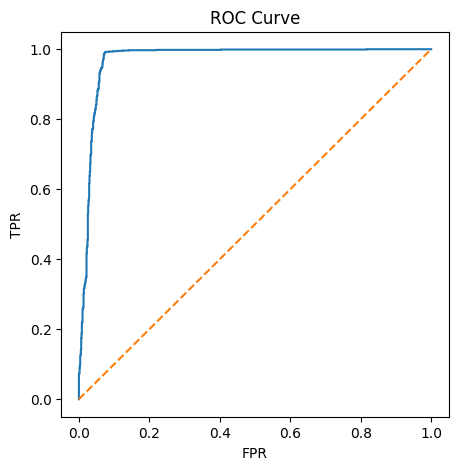

In [ ]:
# ROC Curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_test_score)
plt.figure(figsize=(5,5))
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

In [ ]:
# Control del overfitting
for i in range(1,35):
    dt2 = RandomForestClassifier(max_depth=i, random_state=42, n_estimators=100)
    dt2.fit(X_train, y_train)
    acc_train = dt2.score(X_train, y_train)
    acc_test = dt2.score(X_test, y_test)
    print(f'Profundidad del arbol: {i}, Acc. train: {np.round(acc_train,3)}, Acc. test: {np.round(acc_test,3)}')

Profundidad del arbol: 1, Acc. train: 0.825, Acc. test: 0.827
Profundidad del arbol: 2, Acc. train: 0.9, Acc. test: 0.91
Profundidad del arbol: 3, Acc. train: 0.915, Acc. test: 0.925
Profundidad del arbol: 4, Acc. train: 0.937, Acc. test: 0.955
Profundidad del arbol: 5, Acc. train: 0.937, Acc. test: 0.949
Profundidad del arbol: 6, Acc. train: 0.929, Acc. test: 0.942
Profundidad del arbol: 7, Acc. train: 0.938, Acc. test: 0.955
Profundidad del arbol: 8, Acc. train: 0.935, Acc. test: 0.955
Profundidad del arbol: 9, Acc. train: 0.938, Acc. test: 0.956
Profundidad del arbol: 10, Acc. train: 0.939, Acc. test: 0.956
Profundidad del arbol: 11, Acc. train: 0.94, Acc. test: 0.957
Profundidad del arbol: 12, Acc. train: 0.94, Acc. test: 0.957
Profundidad del arbol: 13, Acc. train: 0.941, Acc. test: 0.957
Profundidad del arbol: 14, Acc. train: 0.941, Acc. test: 0.957
Profundidad del arbol: 15, Acc. train: 0.944, Acc. test: 0.957
Profundidad del arbol: 16, Acc. train: 0.944, Acc. test: 0.957
Profun

# 9. Predicción de la probabilidad de compra de payroll para el último mes
Se realiza una predicción de la probabilidad de que cada cliente compre payroll en el último mes. Estos resultados se ordenan por probabilidad y se guardan en un archivo CSV.

In [ ]:
# Creamos el conjunto de datos para el último mes
last_month_df = df_grouped[df_grouped['pk_partition'] == last_month]

# Excluimos a los clientes que ya tienen un payroll
last_month_df = last_month_df[last_month_df[target] == 0]

# Excluimos las ventas
X_last_month = last_month_df[features].copy()

# Normalizamos las características numéricas
X_last_month.loc[:, numeric_features] = scaler.transform(X_last_month[numeric_features])

# Hacemos las predicciones de probabilidad con el modelo
probs = model.predict_proba(X_last_month)

# Conservamos solo la probabilidad de la clase positiva
probs = probs[:, 1]

# Creamos un DataFrame para los resultados
results_payroll = pd.DataFrame({
    'pk_cid': last_month_df['pk_cid'],  # reemplazar 'CustomerID' con tu columna de identificación de clientes
    'Probability_payroll': probs
})

# Ordenamos de mayor a menor probabilidad
results_payroll = results_payroll.sort_values(by='Probability_payroll', ascending=False)

# Mostramos los resultados
print(results_payroll)



         pk_cid  Probability_payroll
415661  1515589             0.953570
398474  1495610             0.953350
429267  1534180             0.952920
425500  1528874             0.950531
420157  1521452             0.950002
...         ...                  ...
221655  1279929             0.021266
222205  1280622             0.021097
220789  1278855             0.021043
217234  1274454             0.020605
220824  1278900             0.020605

[392370 rows x 2 columns]


In [ ]:
# Supongamos que 'pk_cid' es la columna con los identificadores de cliente
# y 'proba' es la columna con las probabilidades predichas
positive_cid3 = results_payroll[results_payroll['Probability_payroll'] > 0.0]['pk_cid']

# Ahora cruza esto con tu dataframe original
cross_check3 = df[df['pk_cid'].isin(positive_cid3)]

# Verifica que todos los valores en 'pension_plan' son 0
if all(cross_check3['payroll'] == 0):
    print("Funciona correctamente: Los resultados de probabilidad positiva tienen valor 0 en la columna!")
else:
    raise ValueError("Error en la probabilidad")

Funciona correctamente: Los resultados de probabilidad positiva tienen valor 0 en la columna!


# 10. Búsqueda de hiperparámetros óptimos
Se realiza una búsqueda aleatoria de hiperparámetros para encontrar la mejor combinación de parámetros para el modelo de Random Forest.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

## Definir el rango de parámetros para la búsqueda aleatoria
param_dist = {"max_depth": randint(10, 15),
              "n_estimators": randint(50, 100),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# Crear una nueva instancia del modelo RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Realizar la búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=50, cv=5, random_state=42)
random_search.fit(X_train, y_train)

# Ver los mejores parámetros encontrados
print("Mejores parámetros: ", random_search.best_params_)

# Utilizar el mejor modelo para hacer predicciones
best_rf = random_search.best_estimator_


Mejores parámetros:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 14, 'n_estimators': 85}


# 11. Análisis de correlación de las variables con el target
Se realiza un análisis de correlación para identificar las variables que tienen una mayor correlación con la variable objetivo, lo que puede indicar qué variables son más importantes para la predicción.

In [ ]:
correlation_with_target = df_grouped.corr()[target]
correlation_with_target = correlation_with_target.drop(target)
sorted_correlations = correlation_with_target.sort_values(ascending=False)
print(sorted_correlations)

<ipython-input-39-1c63af0904c5>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_with_target = df_grouped.corr()[target]


Suma_productos_activos        0.557702
segment_02 - PARTICULARES     0.156400
entry_channel_KFC             0.134183
age                           0.091136
entry_channel_KAT             0.071965
                                ...   
gender_M                     -0.024568
pk_cid                       -0.031220
entry_channel_KHQ            -0.100423
entry_channel_KHE            -0.133149
segment_03 - UNIVERSITARIO   -0.158808
Name: payroll, Length: 171, dtype: float64


In [ ]:
corr = df_grouped.corr()

<ipython-input-40-27b27b39aada>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_grouped.corr()


In [ ]:
corr.style.background_gradient(cmap='coolwarm')

# 12. Descargamos el archivo con la propabilidad por cliente

In [ ]:
from google.colab import files

# Guardar el dataframe en un archivo CSV
results_payroll.to_csv('results_payroll.csv', index=False)

# Descargar el archivo CSV
files.download('results_payroll.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>